In [1]:
from multirotor import *
from lib.dds.dds import *

In [2]:
dds = DDS()
dds.start()

dds.subscribe(['start','tick', 'X', 'Y', 'Z', 'TX', 'TY', 'TZ', 'VX', 'VY', 'VZ', 'WX', 'WY', 'WZ'])
robot = Multirotor()

t = Time(use_fake_time=True)
t.start()

while True:
    dds.wait('tick')
    t.sleep(0.01)
    delta_t = t.elapsed()
    
    dds.publish('attached', 1, DDS.DDS_TYPE_INT)
    dds.wait('tick')
    dds.publish('attached', 0, DDS.DDS_TYPE_INT)
    break



FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO
AAAAAAAAAAAAAAA


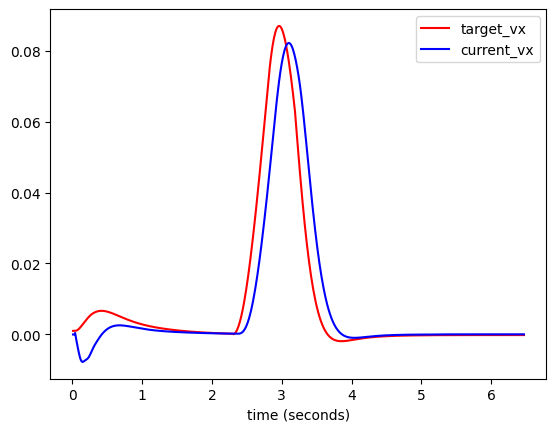

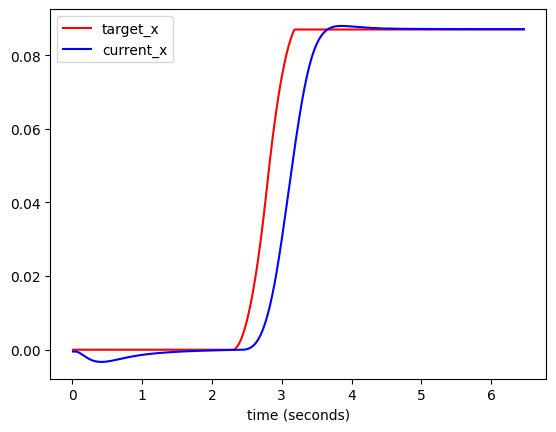

Done


In [ ]:
packet_one_pos = [-0.976, 0.087]

dpvz = DataPlotter()
dpvz.set_x("time (seconds)")
dpvz.add_y("target_vx", "target_vx")
dpvz.add_y("current_vx", "current_vx")

dpz = DataPlotter()
dpz.set_x("time (seconds)")
dpz.add_y("target_x", "target_x")
dpz.add_y("current_x", "current_x")

robot = Multirotor()

move_list = [ ZMovement(robot, 1.0), 
              XYMovement(robot, packet_one_pos[1], packet_one_pos[0]),
              ZMovement(robot, 0.1)]

move_command = move_list.pop(0)
move_command.start()

t = Time(use_fake_time=True)
t.start()

while t.get() < 15:
    dds.wait('tick')
    t.sleep(0.01)
    delta_t = t.elapsed()
    
    z = dds.read('Z')
    vz = dds.read('VZ')
    
    x = dds.read('X')
    vx = dds.read('VX')
    
    y = dds.read('Y')
    vy = dds.read('VY')
    
    roll = dds.read('TX')
    roll_rate = dds.read('WX')
    
    pitch = dds.read('TY')
    pitch_rate = dds.read('WY')
    
    (f1, f2, f3, f4) = robot.evaluate(delta_t, z, vz, x, vx, y, vy, roll, roll_rate, pitch, pitch_rate)

    move_command.evaluate(delta_t)
    
    if move_command.movement_done():
        print("FINITO MOVIMENTO")
        
        if move_list == []:
            print("FINITO")
            break
            
        move_command = move_list.pop(0)
        move_command.start()

    dds.publish('f1', f1, DDS.DDS_TYPE_FLOAT)
    dds.publish('f2', f2, DDS.DDS_TYPE_FLOAT)
    dds.publish('f3', f3, DDS.DDS_TYPE_FLOAT)
    dds.publish('f4', f4, DDS.DDS_TYPE_FLOAT)
    
    dpvz.append_x(t.get())
    dpvz.append_y("target_vx", robot.vx_target)
    dpvz.append_y("current_vx", vx)

    dpz.append_x(t.get())
    dpz.append_y("target_x", robot.x_target)
    dpz.append_y("current_x", x)


print("AAAAAAAAAAAAAAA")
dds.publish('f1', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f2', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f3', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f4', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('attached', 2, DDS.DDS_TYPE_INT)
dds.wait('tick')
dds.publish('attached', 0, DDS.DDS_TYPE_INT)

dds.stop()
dpvz.plot()
dpz.plot()

print("Done")